<a href="https://colab.research.google.com/github/claudiaxpreda/SRI-Project/blob/main/SRI_Project_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps:


* Cleaned the iriginal dataset and kept the values we were interested in:
    * URL
    * Relvance 
    * Year 
    * Title 
    * Description 

* Converted the new crawled articles in the format of the original dataset
* Merged additional labeled articles in the original dataset:
    * Transformed the columns to match the original format 
    * Merged the articles 

* Extracted the site where the new articles were published to see the new statistics 



In [ ]:
import pandas as pd
import json
import re

from urllib.parse import urlparse

In [ ]:
PATH_LABELED_DATA = 'DataSetYggdrasil-1000Articlesv2.xlsx'
PATH_NEW_DATA = '3090_articles_cronjob.json'

LABELED_ORIGINAL = 'dataset_original_1000.cvs'

def read_xlxs(path):
  return pd.read_excel(path)

def create_csv(path, dataframe):
  dataframe.to_csv(path)

def create_excel(path, dataframe):
  dataframe.to_excel(path)


In [ ]:
# Extract necessary columns: URL, Title, Description, Year 
# Create a CVS file 

def transform_original_dataset(path):
  columns_to_copy = ['URL','Year', 'Final verdict', 'Title', 'Entire Text']
  labeled_data = read_xlxs(PATH_LABELED_DATA)
  labeled_data_new = labeled_data[columns_to_copy].copy()

  labeled_data_new.rename(columns={'Final verdict': 'Relevance', 
                                   'Entire Text' : 'Description'}, inplace=True)
  return labeled_data_new

def transform_new_dataset(path):
  columns_to_copy = ['url', 'date_publish', 'relevance', 'title', 'maintext']
  new_data_file = open(PATH_NEW_DATA)
  new_data_json = json.load(new_data_file)
  new_data_records = [item['Article'] for item in new_data_json]
  new_data = pd.DataFrame.from_records(new_data_records)
  new_data_clean = new_data[columns_to_copy].copy()
  new_data_clean['date_publish'] = new_data['date_publish'].str[:4]

  new_data_clean.rename(columns={'url': 'URL', 'date_publish' : 'Year', 
                                 'relevance' : 'Relevance', 'title' : 'Title', 
                                 'maintext' : 'Description'}, inplace=True)
  
  return new_data_clean


def add_source(path):
  new_data_clean = transform_new_dataset(path)
  new_data_clean['Source'] =  new_data['URL'].apply(lambda item : urlparse(item).netloc.split('.')[0])
  return new_data_clean

def add_source_dataframe(data):
  data['Source'] =  data['URL'].apply(lambda item : urlparse(item).netloc.split('.')[0])
  return data

def select_new_labeled_data(path):
  new_data = transform_new_dataset(PATH_NEW_DATA)
  new_data_labeled = new_data[~new_data['Relevance'].isnull()]
  return new_data_labeled

def select_new_unlabeled_data(path):
  new_data = transform_new_dataset(PATH_NEW_DATA)
  new_data_unlabeled = new_data[new_data['Relevance'].isnull()]
  new_data_unlabeled = new_data_unlabeled.drop('Relevance', axis='columns')
  return new_data_unlabeled

def merge_labeled_data():
  original_data = transform_original_dataset(PATH_LABELED_DATA)
  new_data = select_new_labeled_data(PATH_NEW_DATA)
  all_labeled_data = pd.concat([original_data, new_data], ignore_index=True)

  if all_labeled_data['URL'].duplicated().sum() != 0: 
    all_labeled_data = all_labeled_data.drop_duplicates(subset=['URL'], keep='last')

  return all_labeled_data

def replace_source_labels(df):

  df['Source'] = df['Source'].replace(['arstechnica','thehackernews','securityaffairs', 'threarpost'],
                                      ['Ars Technica','The Hacker News', 'Security Affairs', 'Threatpost'])
  return df 


# Write to files the data
def original_data_csv(path):
  labeled_data_new = transform_original_dataset(path)
  create_csv(LABELED_ORIGINAL, labeled_data_new)
  create_excel('dataset_original_1000.xlsx', labeled_data_new)


def add_source_create_csv(path):
  new_data_clean = add_source(path)
  create_csv('new_all_data_source.csv', new_data_clean)
  create_excel('new_all_data_source.xlsx', new_data_clean)


def new_labeled_data_csv(path):
  new_data_labeled = select_new_labeled_data(path)
  create_csv('new_labeled_data.csv', new_data_labeled)
  create_excel('new_labeled_data.xlsx', new_data_labeled)


def new_unlabeled_data_csv(path):
  new_data_unlabeled = select_new_unlabeled_data(path)
  create_csv('new_unlabeled_data.csv', new_data_unlabeled)
  create_excel('new_unlabeled_data.xlsx', new_data_unlabeled)


def final_labeled_data():
  final_labeled_data = merge_labeled_data()
  create_csv('final_labeled_data.csv', final_labeled_data)
  create_excel('final_labeled_data.xlsx', final_labeled_data)



In [ ]:
final_labeled_data = pd.read_csv('new_labeled_data.csv')
final_labeled_data.drop(final_labeled_data.columns[0], axis=1, inplace=True)

In [ ]:
# Number of articles grouped by year/source - labeled/unlabeled 
final_labeled_data = add_source_dataframe(final_labeled_data)
final_labeled_data.head(10)

,URL,Year,Relevance,Title,Description,Source
0,https://securityaffairs.co/wordpress/124066/ma...,2021,Irrelevant,The Toronto Transit Commission (TTC) hit by a ...,A ransomware attack hit the systems at the Tor...,securityaffairs
1,https://thehackernews.com/2021/11/alert-hacker...,2021,Relevant,Alert! Hackers Exploiting GitLab Unauthenticat...,A now-patched critical remote code execution (...,thehackernews
2,https://thehackernews.com/2021/11/google-to-pa...,2021,Relevant,"Google to Pay Hackers $31,337 for Exploiting P...",Google on Monday announced that it will pay se...,thehackernews
3,https://securityaffairs.co/wordpress/124059/ma...,2021,Irrelevant,HelloKitty ransomware gang also targets victim...,The US FBI has published a flash alert warning...,securityaffairs
4,https://securityaffairs.co/wordpress/124047/cy...,2021,Irrelevant,Squid Game Cryptocurrency exit scam! Operators...,Operators behind the Squid Game cryptocurrency...,securityaffairs
5,https://securityaffairs.co/wordpress/124038/ha...,2021,Irrelevant,How to hack Wincor Cineo ATMs to bypass black-...,Researchers demonstrated how crooks could hack...,securityaffairs
6,https://securityaffairs.co/wordpress/124027/ma...,2021,Irrelevant,Pink Botnet infected over 1.6 Million DevicesS...,Cybersecurity researchers uncovered a huge bot...,securityaffairs
7,https://securityaffairs.co/wordpress/124017/ap...,2021,Irrelevant,Balikbayan Foxes group spoofs Philippine gov t...,Meet Balikbayan Foxes: a threat group imperson...,securityaffairs
8,https://securityaffairs.co/wordpress/124006/ha...,2021,Irrelevant,Microsoft warns of an increase in password spr...,The Microsoft Detection and Response Team (DAR...,securityaffairs
9,https://thehackernews.com/2021/11/critical-fla...,2021,Relevant,Critical Flaws Uncovered in Pentaho Business A...,Multiple vulnerabilities have been disclosed i...,thehackernews


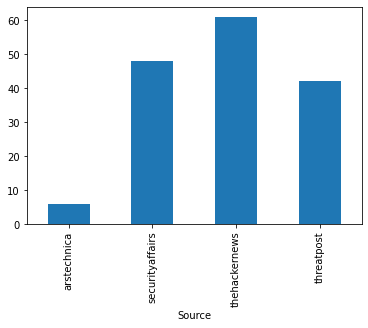

In [ ]:
import seaborn as sns
final_labeled_data.groupby(['Source']).size().plot(kind = "bar")

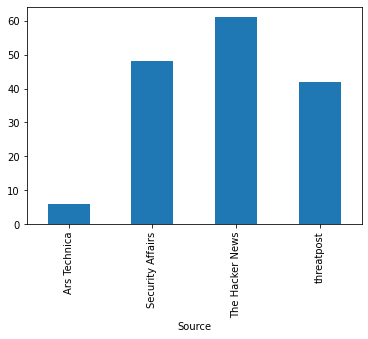

In [ ]:
final_labeled_data_names = replace_source_labels(final_labeled_data)
final_labeled_data.groupby(['Source',]).size().plot(kind = "bar")

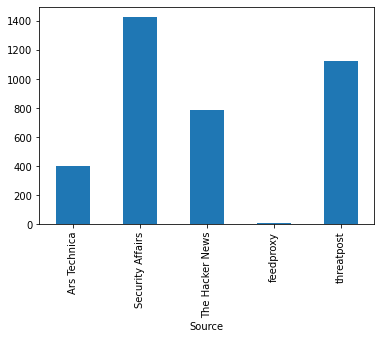

In [ ]:
unlabeled_data = pd.read_csv('new_unlabeled_data.csv')
unlabeled_data = add_source_dataframe(unlabeled_data)
unlabeled_data = replace_source_labels(unlabeled_data)
unlabeled_data.groupby(['Source']).size().plot(kind = "bar")

In [ ]:
print("Labeled data statistics - Source")
print(final_labeled_data_names.groupby(['Source']).size())
print("Labeled data statistics - Year")
print(final_labeled_data_names.groupby(['Year']).size())
print("Labeled data statistics - Source/Year")
print(final_labeled_data_names.groupby(['Source','Year']).size())

Labeled data statistics - Source
Source
Ars Technica         6
Security Affairs    48
The Hacker News     61
threatpost          42
dtype: int64
Labeled data statistics - Year
Year
2018      1
2019      6
2020      2
2021    148
dtype: int64
Labeled data statistics - Source/Year
Source            Year
Ars Technica      2021     6
Security Affairs  2021    48
The Hacker News   2021    61
threatpost        2018     1
                  2019     6
                  2020     2
                  2021    33
dtype: int64


In [ ]:
print("Unlabeled data statistics - Source")
print(unlabeled_data.groupby(['Source']).size())
print("Unlabeled data statistics - Year")
print(unlabeled_data.groupby(['Year']).size())
print("Unlabeled data statistics - Source/Year")
print(unlabeled_data.groupby(['Source','Year']).size())

Unlabeled data statistics - Source
Source
Ars Technica         404
Security Affairs    1427
The Hacker News      790
feedproxy              8
threatpost          1123
dtype: int64
Unlabeled data statistics - Year
Year
2013       3
2014       1
2015       2
2016      10
2017      10
2018      56
2019      96
2020     534
2021    3040
dtype: int64
Unlabeled data statistics - Source/Year
Source            Year
Ars Technica      2018       1
                  2020      35
                  2021     368
Security Affairs  2020     166
                  2021    1261
The Hacker News   2020      44
                  2021     746
feedproxy         2021       8
threatpost        2013       3
                  2014       1
                  2015       2
                  2016      10
                  2017      10
                  2018      55
                  2019      96
                  2020     289
                  2021     657
dtype: int64


In [ ]:
final_labeled_data_names['Word count'] = final_labeled_data_names['Description'].apply(lambda item : len(item.split()))
print('Minimum words in labeled data: {}'.format(final_labeled_data_names['Word count'].min()))
print('Maximum words in labeled data: {}'.format(final_labeled_data_names['Word count'].max()))
print('Average words in labeled data: {}'.format(final_labeled_data_names['Word count'].mean()))

Minimum words in labeled data: 206
Maximum words in labeled data: 2045
Average words in labeled data: 634.1974522292994


In [ ]:
unlabeled_data['Word count'] = unlabeled_data['Description'].apply(lambda item : len(item.split()))
print('Minimum words in unlabeled data: {}'.format(unlabeled_data['Word count'].min()))
print('Maximum words in unlabeled data: {}'.format(unlabeled_data['Word count'].max()))
print('Average words in unlabeled data: {}'.format(unlabeled_data['Word count'].mean()))

Minimum words in unlabeled data: 46
Maximum words in unlabeled data: 11164
Average words in unlabeled data: 668.5810234541577
